In [2]:
base_path = 'C:/Users/User/Downloads/LDAPS_Data'

In [3]:
import os
import numpy as np
import pandas as pd
from windpowerlib.wind_speed import logarithmic_profile
from windpowerlib.modelchain import ModelChain
from windpowerlib.wind_turbine import WindTurbine
import matplotlib.pyplot as plt
META_PATH = os.path.join(base_path, "windfarm_metadata.xlsx")
# META_PATH = "C:/Users/User/Downloads/공모전 제공용 데이터 및 예제/1-2. windfarm_metadata.xlsx"
POWER_CURVE_PATH = os.path.join(base_path, "Power_curves_20210323.xls")
GJ_LDAPS_PATH = os.path.join(base_path, "gyeongju_ldaps_20_23.pkl")
GJ_LDAPS_TRAIN_PATH = os.path.join(base_path, "ldaps_memory_optimization/ldaps_memory_optimization/train_ldaps_gyeongju.parquet")
GJ_LDAPS_TEST_PATH = os.path.join(base_path, "test_ldaps_gyeongju.parquet")
YG_LDAPS_PATH = os.path.join(base_path, "yeonggwang_ldaps_20_23.pkl")
YG_LDAPS_TRAIN_PATH = os.path.join(base_path, "ldaps_memory_optimization/ldaps_memory_optimization/train_ldaps_yeonggwang.parquet")
YG_LDAPS_TEST_PATH = os.path.join(base_path, "ldaps_memory_optimization/ldaps_memory_optimization/test_ldaps_yeonggwang.parquet")
TRAIN_Y_PATH = os.path.join(base_path, "train_y.csv")

# YG_REPORT_PATH1 = os.path.join(base_path, "memory_optimized/memory_optimized/dynamic_report_ewp004_202001_202007.parquet")
# YG_REPORT_PATH2 = os.path.join(base_path, "memory_optimized/memory_optimized/dynamic_report_ewp004_202008_202012.parquet")
# YG_REPORT_PATH3 = os.path.join(base_path, "memory_optimized/memory_optimized/dynamic_report_ewp004_202101_202106.parquet")
# YG_REPORT_PATH4 = os.path.join(base_path, "memory_optimized/memory_optimized/dynamic_report_ewp004_202107_202112.parquet")
# YG_REPORT_PATH5 = os.path.join(base_path, "memory_optimized/memory_optimized/dynamic_report_ewp004_202201_202206.parquet")
# YG_REPORT_PATH6 = os.path.join(base_path, "memory_optimized/memory_optimized/dynamic_report_ewp004_202207_202212.parquet")

In [4]:
def uv_to_wsd(u_wind_speed, v_wind_speed):
    """ 
        Convert u, v vector to wind speed and direction.
    """
    u_ws = u_wind_speed.to_numpy()
    v_ws = v_wind_speed.to_numpy()

    # NOTE: http://colaweb.gmu.edu/dev/clim301/lectures/wind/wind-uv
    wind_speed = np.nansum([u_ws**2, v_ws**2], axis=0)**(1/2.)

    # math degree
    wind_direction = np.rad2deg(np.arctan2(v_ws, u_ws+1e-6))
    wind_direction[wind_direction < 0] += 360

    # meteorological degree
    wind_direction = 270 - wind_direction
    wind_direction[wind_direction < 0] += 360

    return wind_speed, wind_direction

In [6]:
# check metadata
gj_meta = pd.read_excel(META_PATH, sheet_name=1, skiprows=1).iloc[:, 1:]
gj_meta.head()

,발전단지,발전기 번호,제작사 turbine ID,터빈 모델,정격 출력 [kW],소재지표고(지표) [m],허브 높이(지표) [m],로터 반경 [m],위도,경도,비고
0,경주풍력,WTG01,UNISON,U113,2300,492.0,100,56.5,35.724089,129.374592,NaN
1,경주풍력,WTG02,UNISON,U113,2300,456.1,100,56.5,35.722233,129.372400,NaN
2,경주풍력,WTG03,UNISON,U113,2300,476.5,100,56.5,35.721336,129.370150,NaN
3,경주풍력,WTG04,UNISON,U113,2300,467.1,100,56.5,35.719208,129.368869,NaN
4,경주풍력,WTG05,UNISON,U113,2300,502.2,100,56.5,35.716156,129.367767,NaN


Text(0, 0.5, 'power [kWh]')

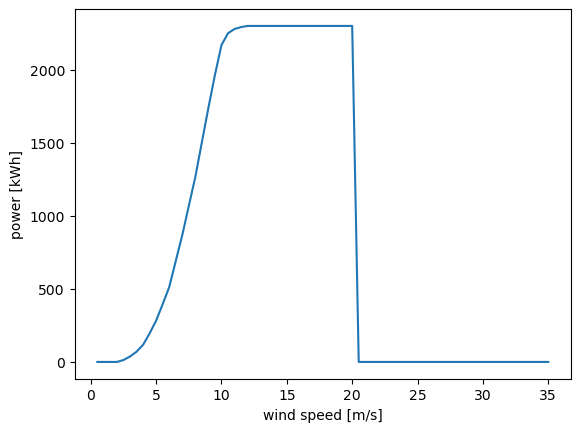

In [7]:
# 발전소 정보(메타데이터)에 기재된 파워커브를 사전에 제공된 리스트에서부터 검색
power_curve = pd.read_excel(POWER_CURVE_PATH, sheet_name=2, skiprows=1)
pc_unison_u113 = power_curve.loc[power_curve.iloc[:,3] == "U113"].\
    iloc[0,5:75].to_dict()
# 파워커브는 발전량-풍속 간 관계식이며, dictionary의 key=풍속, value=출력
plt.plot(pc_unison_u113.keys(), pc_unison_u113.values())
plt.xlabel("wind speed [m/s]")
plt.ylabel("power [kWh]")

In [8]:
gj_train = pd.read_parquet(GJ_LDAPS_TRAIN_PATH)
gj_train.head()

,dt,elevation,land_cover,surf_rough,frictional_vmax_50m,frictional_vmin_50m,pressure,relative_humid,specific_humid,temp_air,storm_u_5m,storm_v_5m,wind_u_10m,wind_v_10m,turbine_id
0,2020-01-02 00:00:00+09:00,387.640625,1.0,0.286911,10.428498,10.059580,97974.593750,91.796478,0.002686,269.467560,0.021201,-0.375756,7.353266,-2.640615,WTG01
1,2020-01-02 01:00:00+09:00,387.640625,1.0,0.286911,10.472921,10.044404,97970.132812,91.729774,0.002686,269.430847,0.020706,-0.371947,7.578446,-2.414076,WTG01
2,2020-01-02 02:00:00+09:00,387.640625,1.0,0.286911,10.682985,10.478634,97951.546875,92.788666,0.002686,269.374390,0.020556,-0.354397,7.654554,-2.259913,WTG01
3,2020-01-02 03:00:00+09:00,387.640625,1.0,0.286911,10.676681,10.090029,97908.968750,92.494576,0.002686,269.352112,0.021635,-0.328609,7.275844,-2.280371,WTG01
4,2020-01-02 04:00:00+09:00,387.640625,1.0,0.286911,10.079557,9.672620,97858.398438,88.986443,0.002686,269.413269,0.024231,-0.265124,6.911751,-1.920128,WTG01


In [9]:
yg_train = pd.read_parquet(YG_LDAPS_TRAIN_PATH)
yg_train.head()

,dt,elevation,land_cover,surf_rough,frictional_vmax_50m,frictional_vmin_50m,pressure,relative_humid,specific_humid,temp_air,storm_u_5m,storm_v_5m,wind_u_10m,wind_v_10m,turbine_id
0,2020-01-02 00:00:00+09:00,0.15625,0.021042,0.004259,3.177766,2.558847,103028.843750,61.177334,0.003413,280.260773,0.028556,-0.041619,2.841913,-4.775259,WTG01
1,2020-01-02 01:00:00+09:00,0.15625,0.021042,0.004250,3.907736,3.248139,103004.507812,61.698036,0.003413,280.260681,0.042130,-0.044463,3.091386,-3.758680,WTG01
2,2020-01-02 02:00:00+09:00,0.15625,0.021042,0.004248,3.552126,3.160641,102999.546875,62.101166,0.003418,280.268921,0.034533,-0.028805,3.005262,-3.511989,WTG01
3,2020-01-02 03:00:00+09:00,0.15625,0.021042,0.004248,3.269210,2.882998,102988.968750,61.944283,0.003418,280.276672,0.025693,-0.028163,2.610194,-3.798681,WTG01
4,2020-01-02 04:00:00+09:00,0.15625,0.021042,0.004248,3.065275,2.887952,102937.523438,61.080189,0.003418,280.266052,0.036102,-0.031177,2.678841,-3.966148,WTG01


In [10]:
yg_train.columns

Index(['dt', 'elevation', 'land_cover', 'surf_rough', 'frictional_vmax_50m',
       'frictional_vmin_50m', 'pressure', 'relative_humid', 'specific_humid',
       'temp_air', 'storm_u_5m', 'storm_v_5m', 'wind_u_10m', 'wind_v_10m',
       'turbine_id'],
      dtype='object')

# 컬럼 정리
### (권용민 님)
- dt : datetime
- elevation : 고도
- land_cover : land COVER
- surf_rough : surface roughness
- frictional_vmax_50m : 마찰속도 max?
- frictional_vmin_50m : 마찰속도 min?
    - 마찰속도 : ~~정적 중립 상태인 경계층에서~~ 수평 방향의 확산(혼합)을 설명하는 값
    - 수평성분과 연직성분의 공분산
- pressure : 기압(Pa)
    - 100으로 나눠주면 hPa 단위
    - (어느 고도에서인지는 모르겠음)
- relative_humid : 상대습도
- specific_humid : 비습
    - (습윤공기 1kg 안에 들어있는 수증기의 양(g))
- temp_air : 대기 온도 (K)
    - 섭씨로 바꾸려면 -273.15 하면 됨
    - (어느 고도에서인지는 모르겠음)
- storm_u_5m
- storm_v_5m
- wind_u_10m 뭔지 모르겠음.. 지표에서 10m 상공의 바람? 10분 평균 바람?
- wind_v_10m
- turbine_id
- wind_speed : 풍속
- wind_direction : 풍향

In [11]:
print(gj_train.shape, yg_train.shape)

(235818, 15) (917070, 15)


In [12]:
train_df = pd.concat([gj_train, yg_train], ignore_index=True)
train_df.shape

(1152888, 15)

In [13]:
correlation =train_df.corr(numeric_only=True)

In [14]:
train_y = pd.read_csv(TRAIN_Y_PATH)
train_y.end_datetime = pd.to_datetime(
    train_y.end_datetime
).dt.tz_convert("Asia/Seoul")
gj_y = train_y[train_y.plant_name == "경주풍력"]
yg_y = train_y[train_y.plant_name == "영광풍력"]

In [15]:
print(gj_y.shape, yg_y.shape)

(26304, 4) (26304, 4)


In [16]:
gj_y.head()

,plant_name,end_datetime,period_hours,energy_kwh
0,경주풍력,2020-01-01 01:00:00+09:00,1,9767.578125
1,경주풍력,2020-01-01 02:00:00+09:00,1,5381.835938
2,경주풍력,2020-01-01 03:00:00+09:00,1,3021.484375
3,경주풍력,2020-01-01 04:00:00+09:00,1,4400.390625
4,경주풍력,2020-01-01 05:00:00+09:00,1,4501.953125


In [17]:
train_df.isna().sum()

dt                     0
elevation              0
land_cover             0
surf_rough             0
frictional_vmax_50m    0
frictional_vmin_50m    0
pressure               0
relative_humid         0
specific_humid         0
temp_air               0
storm_u_5m             0
storm_v_5m             0
wind_u_10m             0
wind_v_10m             0
turbine_id             0
dtype: int64

In [18]:
gj_y.isna().sum()

plant_name      0
end_datetime    0
period_hours    0
energy_kwh      0
dtype: int64

In [19]:
yg_y.isna().sum()

plant_name      0
end_datetime    0
period_hours    0
energy_kwh      0
dtype: int64

In [20]:
# yg_report1 = pd.read_parquet(YG_REPORT_PATH1)
# yg_report2 = pd.read_parquet(YG_REPORT_PATH2)
# yg_report3 = pd.read_parquet(YG_REPORT_PATH3)
# yg_report4 = pd.read_parquet(YG_REPORT_PATH4)
# yg_report5 = pd.read_parquet(YG_REPORT_PATH5)
# yg_report6 = pd.read_parquet(YG_REPORT_PATH6)

In [21]:
# yg_report = pd.concat([yg_report1,yg_report2,yg_report3,yg_report4,yg_report5,yg_report6])

In [22]:
# yg_report['Date/Time'][:5]

In [23]:
# yg_report.dtypes

- **Date/Time**: 날짜와 시간.
- **WTG. Name**: 풍력 터빈의 이름.
- **WTG. Serial**: 풍력 터빈의 시리얼 번호.
- **Availability - Forced Outage Time [Min.]**: 강제 중단 시간(분 단위).
- **Availability - Requested Shutdown Time [Min.]**: 요청된 셧다운 시간(분 단위).
- **Availability - Scheduled Maintenance Time [Min.]**: 예정된 유지보수 시간(분 단위).
- **Availability - Technical Standby Time [Min.]**: 기술적 대기 시간(분 단위).
- **Energy Production - Active Energy Production [KWh]**: 실제 에너지 생산량(KWh 단위).
- **Generator - Average Winding Temp. [℃]**: 발전기 권선의 평균 온도(℃).
- **Grid - Active Power [kW]**: 전력망의 유효 전력(kW).
- **Grid - Reactive Power [kVAr]**: 전력망의 무효 전력(kVAr).
- **Hydraulic System Pressure [bar]**: 유압 시스템 압력(bar).
- **Nacelle - Air Density [kg/㎥]**: 나셀의 공기 밀도(kg/㎥).
- **Nacelle - Outdoor Temp [℃]**: 나셀 외부 온도(℃).
- **Nacelle - Nacelle Position [deg]**: 나셀의 위치(도).
- **Nacelle - Wind Direction [deg]**: 바람의 방향(도).
- **Nacelle - Wind Speed [m/s]**: 풍속(m/s).
- **Rotor - Rotor Speed [rpm]**: 로터 회전 속도(rpm).
- **Yaw - Yaw cable windup position [deg]**: 요 케이블 감김 위치(도).
- **Yaw - Yaw cable windup [deg]**: 요 케이블 감김(도).
- **Availability - Full Performance Time [Min.]**: 완전 가동 시간(분 단위).
- **Rotor - Blade 1 Pos. [deg]**: 로터 블레이드 1 위치(도).
- **Rotor - Blade 2 Pos. [deg]**: 로터 블레이드 2 위치(도).
- **Rotor - Blade 3 Pos. [deg]**: 로터 블레이드 3 위치(도).
- **Rotor - Motor 1 Pos. [deg]**: 로터 모터 1 위치(도).
- **Rotor - Motor 2 Pos. [deg]**: 로터 모터 2 위치(도).
- **Rotor - Motor 3 Pos. [deg]**: 로터 모터 3 위치(도).
- **Rotor - Pitch 1 Angle [deg]**: 로터 피치 1 각도(도).
- **Rotor - Pitch 2 Angle [deg]**: 로터 피치 2 각도(도).
- **Rotor - Pitch 3 Angle [deg]**: 로터 피치 3 각도(도).

In [24]:
# yg_report = yg_report[yg_report['Date/Time'].str.match(r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}$')]
# yg_report['Date/Time'] = pd.to_datetime(yg_report['Date/Time'], format='%Y-%m-%d %H:%M')

# yg_report.interpolate(method='linear', inplace=True)

# yg_report['Date/Time'] = yg_report['Date/Time'].dt.floor('H')
# yg_report = yg_report.groupby('Date/Time').mean(numeric_only=True).reset_index()

In [25]:
print(yg_train.columns)
# print(yg_report.columns)
print(yg_y.columns)

Index(['dt', 'elevation', 'land_cover', 'surf_rough', 'frictional_vmax_50m',
       'frictional_vmin_50m', 'pressure', 'relative_humid', 'specific_humid',
       'temp_air', 'storm_u_5m', 'storm_v_5m', 'wind_u_10m', 'wind_v_10m',
       'turbine_id'],
      dtype='object')
Index(['plant_name', 'end_datetime', 'period_hours', 'energy_kwh'], dtype='object')


In [26]:
# yg_report.head(2)

In [27]:
yg_train.tail()

,dt,elevation,land_cover,surf_rough,frictional_vmax_50m,frictional_vmin_50m,pressure,relative_humid,specific_humid,temp_air,storm_u_5m,storm_v_5m,wind_u_10m,wind_v_10m,turbine_id
917065,2022-12-31 19:00:00+09:00,14.84375,1.0,0.200022,4.003626,3.589689,102833.937500,64.626816,0.003016,274.376099,0.160105,-0.059690,2.328954,-2.438136,WTG35
917066,2022-12-31 20:00:00+09:00,14.84375,1.0,0.200022,3.916099,3.548627,102825.851562,68.772079,0.003124,273.657501,0.116012,-0.029307,2.534976,-1.800539,WTG35
917067,2022-12-31 21:00:00+09:00,14.84375,1.0,0.200022,4.573833,3.845803,102831.773438,68.919632,0.003174,273.419952,0.088966,-0.018179,3.006288,-1.592857,WTG35
917068,2022-12-31 22:00:00+09:00,14.84375,1.0,0.200022,5.136635,4.590230,102843.687500,67.002106,0.003124,273.396545,0.096539,-0.026390,3.306275,-1.771884,WTG35
917069,2022-12-31 23:00:00+09:00,14.84375,1.0,0.200022,5.615887,5.049034,102829.242188,69.130402,0.003174,273.379211,0.091412,-0.024915,3.459226,-1.414026,WTG35


In [28]:
yg_y.head(2)

,plant_name,end_datetime,period_hours,energy_kwh
26304,영광풍력,2020-01-01 01:00:00+09:00,1,15010.949
26305,영광풍력,2020-01-01 02:00:00+09:00,1,21870.458


In [29]:
# print(yg_report.shape)
print(yg_train.shape)
print(yg_y.shape)

(917070, 15)
(26304, 4)


In [30]:
yg_train['dt'] = pd.to_datetime(yg_train['dt'], errors='coerce')
# yg_report['Date/Time'] = pd.to_datetime(yg_report['Date/Time'], errors='coerce')
yg_y['end_datetime'] = pd.to_datetime(yg_y['end_datetime'], errors='coerce')

C:\Users\User\AppData\Local\Temp\ipykernel_17420\329849419.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yg_y['end_datetime'] = pd.to_datetime(yg_y['end_datetime'], errors='coerce')


In [31]:
yg_train.rename(columns={'dt': 'DateTime'}, inplace=True)
# yg_report.rename(columns={'Date/Time': 'DateTime'}, inplace=True)
yg_y.rename(columns={'end_datetime': 'DateTime'}, inplace=True)

# timezone 정보 제거
yg_train['DateTime'] = yg_train['DateTime'].dt.tz_localize(None)
# yg_report['DateTime'] = yg_report['DateTime'].dt.tz_localize(None)
yg_y['DateTime'] = yg_y['DateTime'].dt.tz_localize(None)

C:\Users\User\AppData\Local\Temp\ipykernel_17420\303840702.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yg_y.rename(columns={'end_datetime': 'DateTime'}, inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_17420\303840702.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yg_y['DateTime'] = yg_y['DateTime'].dt.tz_localize(None)


In [33]:
# yg_df = pd.merge(yg_train, yg_report, on='DateTime', how='inner')
yg_df = yg_train
yg_df = pd.merge(yg_df, yg_y, on='DateTime', how='inner')
# yg_df = yg_train

In [34]:
wtg_1_df = yg_df.loc[yg_df['turbine_id']=='WTG01']

In [35]:
wtg_1_df["wind_speed"], wtg_1_df["wind_direction"] = uv_to_wsd(
    wtg_1_df["wind_u_10m"], wtg_1_df["wind_v_10m"]
)

# 35로 나눈게 영광풍력의 평균 발전량이라고 가정. ( 현재 보는건 1번 터빈 한개이기 때문에.)
# !! 절대 이대로 쓰면 안됨 !!
wtg_1_df['energy_kwh'] /= 35

C:\Users\User\AppData\Local\Temp\ipykernel_17420\465088657.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wtg_1_df["wind_speed"], wtg_1_df["wind_direction"] = uv_to_wsd(
C:\Users\User\AppData\Local\Temp\ipykernel_17420\465088657.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wtg_1_df["wind_speed"], wtg_1_df["wind_direction"] = uv_to_wsd(
C:\Users\User\AppData\Local\Temp\ipykernel_17420\465088657.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

In [36]:
wtg_1_df.corr(numeric_only=True)

,elevation,land_cover,surf_rough,frictional_vmax_50m,frictional_vmin_50m,pressure,relative_humid,specific_humid,temp_air,storm_u_5m,storm_v_5m,wind_u_10m,wind_v_10m,period_hours,energy_kwh,wind_speed,wind_direction
elevation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
land_cover,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
surf_rough,NaN,NaN,1.000000,0.056752,0.049049,-0.009704,0.000376,-0.023006,-0.025568,0.030757,-0.083658,0.054772,-0.049059,NaN,0.070473,0.079085,0.029837
frictional_vmax_50m,NaN,NaN,0.056752,1.000000,0.948131,-0.050535,-0.127767,-0.134847,-0.115299,0.540993,-0.358911,0.960433,-0.274572,NaN,0.399440,0.436320,0.613584
frictional_vmin_50m,NaN,NaN,0.049049,0.948131,1.000000,-0.046930,-0.134753,-0.128855,-0.120335,0.506091,-0.331543,0.954622,-0.265223,NaN,0.362070,0.372765,0.622518
pressure,NaN,NaN,-0.009704,-0.050535,-0.046930,1.000000,-0.484596,-0.746518,-0.572921,0.178933,-0.283990,-0.063093,-0.379645,NaN,0.000727,0.001849,-0.061696
relative_humid,NaN,NaN,0.000376,-0.127767,-0.134753,-0.484596,1.000000,0.399059,0.061935,-0.152143,0.344282,-0.146989,0.408755,NaN,-0.160597,-0.226652,-0.098674
specific_humid,NaN,NaN,-0.023006,-0.134847,-0.128855,-0.746518,0.399059,1.000000,0.884929,-0.263488,0.371695,-0.120080,0.442184,NaN,-0.155110,-0.139134,-0.063069
temp_air,NaN,NaN,-0.025568,-0.115299,-0.120335,-0.572921,0.061935,0.884929,1.000000,-0.234943,0.206281,-0.104969,0.241393,NaN,-0.147846,-0.095801,-0.058104
storm_u_5m,NaN,NaN,0.030757,0.540993,0.506091,0.178933,-0.152143,-0.263488,-0.234943,1.000000,-0.220746,0.499412,-0.129572,NaN,0.406524,0.368420,0.332346


In [37]:
wtg_1_df.columns

Index(['DateTime', 'elevation', 'land_cover', 'surf_rough',
       'frictional_vmax_50m', 'frictional_vmin_50m', 'pressure',
       'relative_humid', 'specific_humid', 'temp_air', 'storm_u_5m',
       'storm_v_5m', 'wind_u_10m', 'wind_v_10m', 'turbine_id', 'plant_name',
       'period_hours', 'energy_kwh', 'wind_speed', 'wind_direction'],
      dtype='object')

In [58]:
from sklearn.cluster import KMeans

# wind_direction을 sin, cos 성분으로 분리
wtg_1_df['wind_dir_sin'] = np.sin(np.radians(wtg_1_df['wind_direction']))
wtg_1_df['wind_dir_cos'] = np.cos(np.radians(wtg_1_df['wind_direction']))


C:\Users\User\AppData\Local\Temp\ipykernel_17420\3803438030.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wtg_1_df['wind_dir_sin'] = np.sin(np.radians(wtg_1_df['wind_direction']))
C:\Users\User\AppData\Local\Temp\ipykernel_17420\3803438030.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wtg_1_df['wind_dir_cos'] = np.cos(np.radians(wtg_1_df['wind_direction']))
C:\Users\User\AppData\Local\Temp\ipykernel_17420\3803438030.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [63]:
# wind_speed와 wind_direction을 이용한 k-means clustering
# 논문에 지역마다 클러스터 개수를 다르게 했다는 것으로 보아, 실험적으로 찾아야 하는 내용으로 보임.
# 논문에 언급된 2,3,4,5로 했을 때 중에 가장 corr이 높은걸로 feature를 가져갈거임.
pd.options.mode.chained_assignment = None

best_corr = 0  # 초기 상관계수
best_clusters = None  # 가장 좋은 클러스터링 결과 저장
for n_clusters in range(2,6):
    for _ in range(10):
        kmeans = KMeans(n_clusters=n_clusters, n_init=10)
        wtg_1_df['cluster'] = kmeans.fit_predict(wtg_1_df[['wind_speed', 'wind_direction']])
        
        # cluster와 target 사이의 상관관계 계산
        corr = wtg_1_df[['cluster', 'energy_kwh']].corr().loc['cluster', 'energy_kwh']
        
        if abs(corr) > best_corr:
            best_corr = abs(corr)
            best_clusters = wtg_1_df['cluster'].copy()
    
wtg_1_df['cluster'] = best_clusters

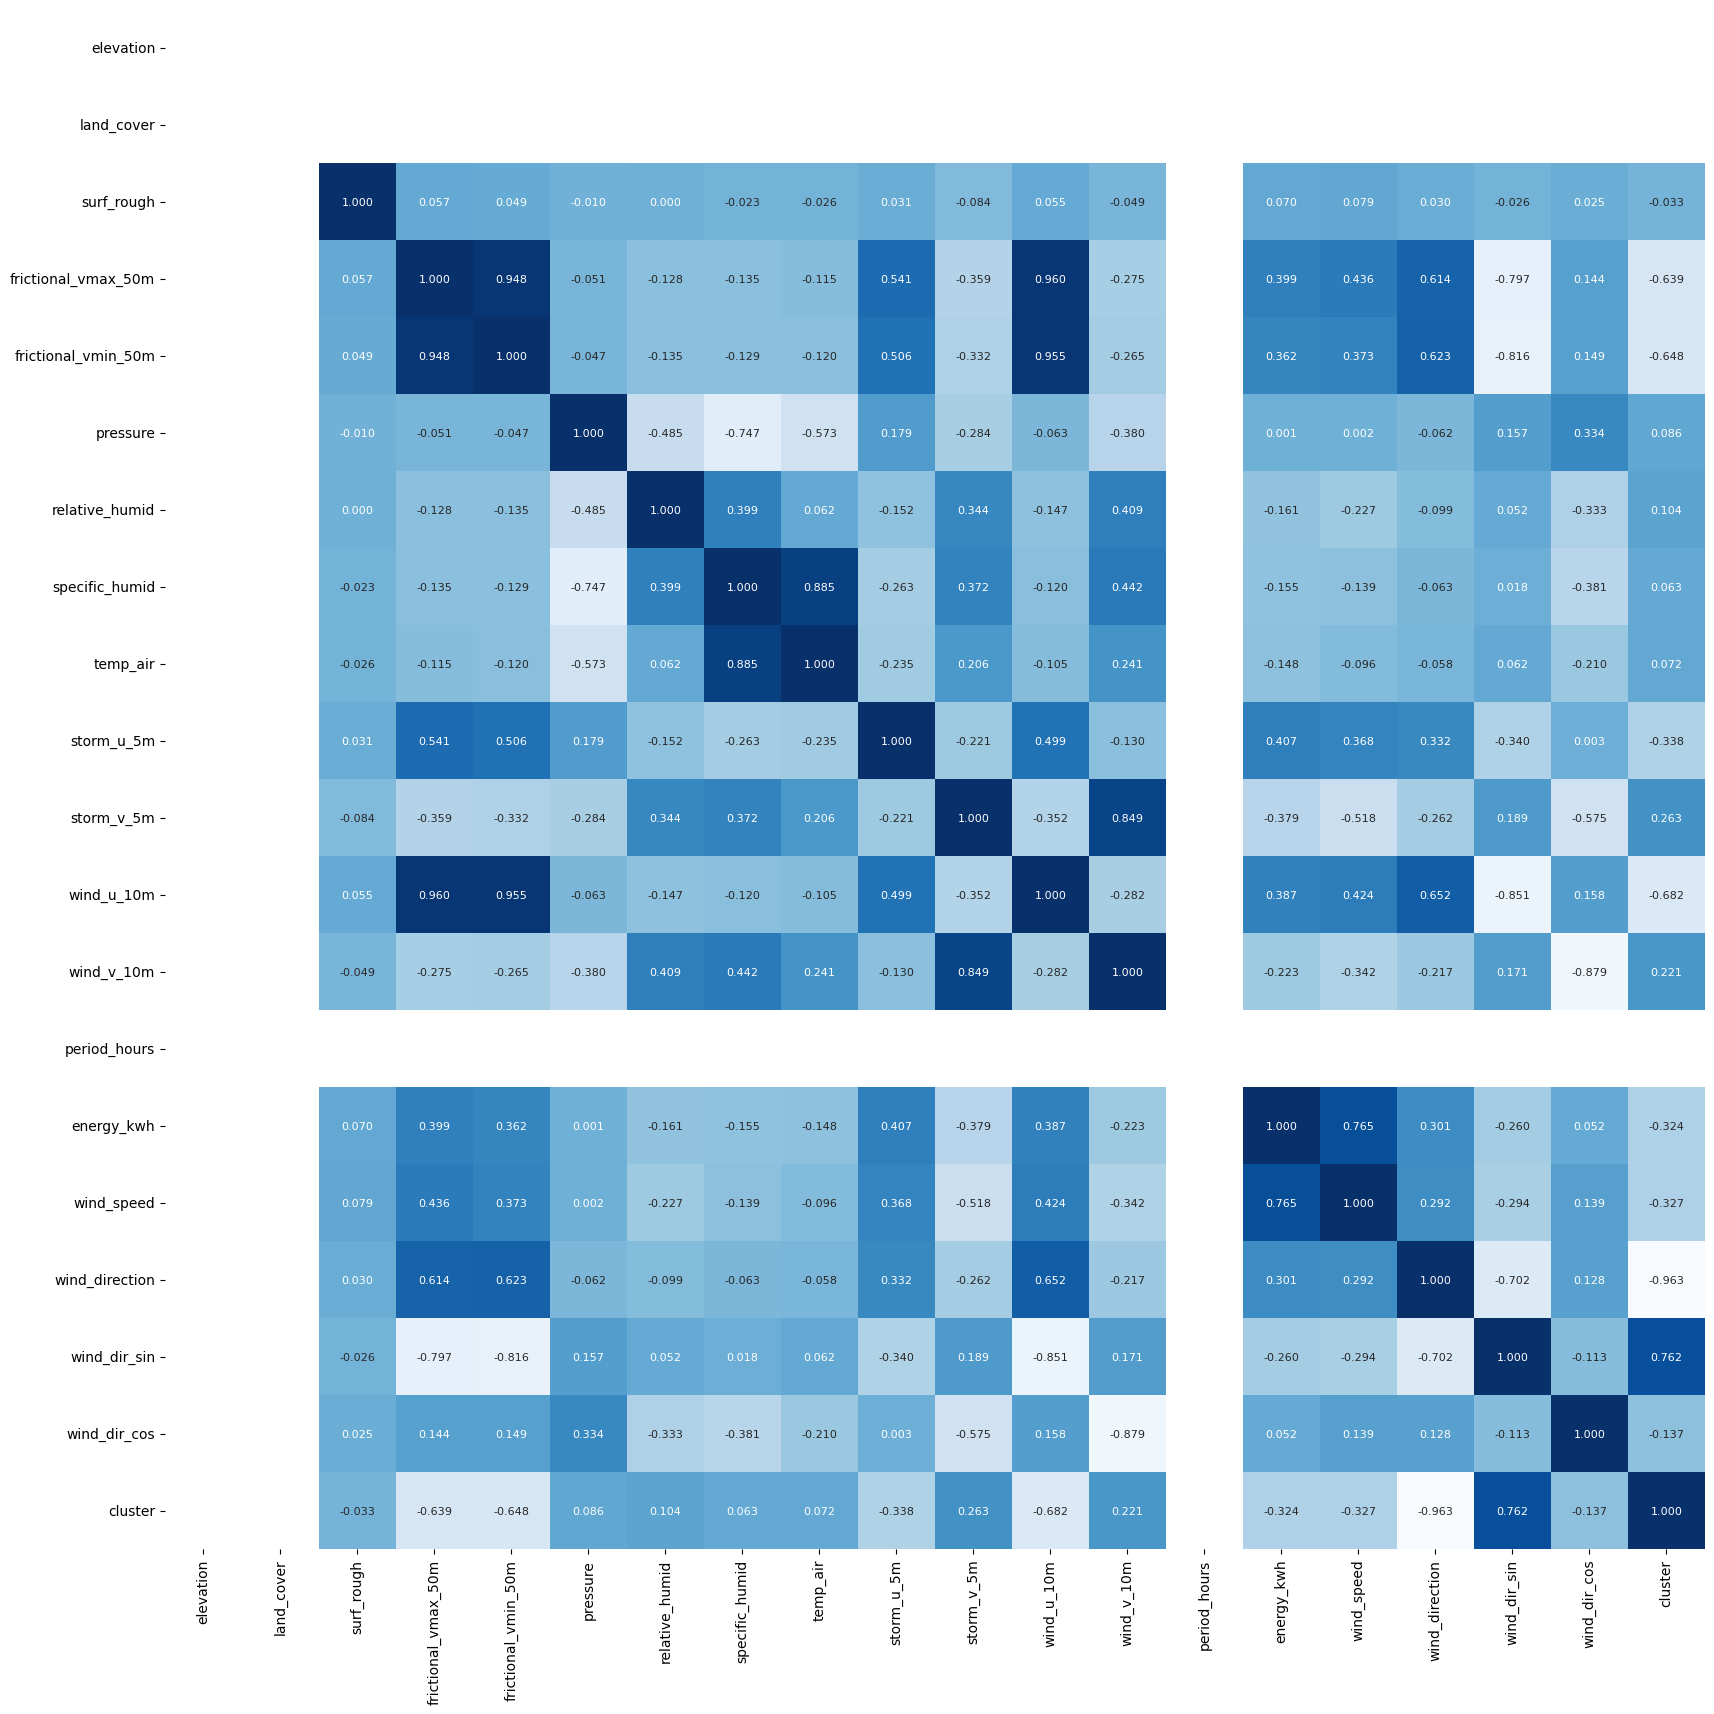

In [64]:
import seaborn as sns
plt.figure(figsize=(20,20))
sns.heatmap(wtg_1_df.corr(numeric_only=True),
            annot=True,
            cmap='Blues',
            cbar=False,
            square=True,
            fmt='.3f',
            annot_kws={'size': 8})

plt.show()

In [65]:
import scipy.stats as spst

# target : energy_kwh
target = 'energy_kwh'

corrs = []

for i in wtg_1_df.columns:
    if i==target or not pd.api.types.is_numeric_dtype(wtg_1_df[i]):
        # memo : is_numeric_dtype함수는 ap.api 안에 들어있음
        continue
    corr,p_val = spst.pearsonr(wtg_1_df[target], wtg_1_df[i])
    if p_val < 0.05 and corr>0.1:
        corrs.append((corr,p_val, i))
        
corrs.sort(reverse=True)

C:\Users\User\AppData\Local\Temp\ipykernel_17420\349439020.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr,p_val = spst.pearsonr(wtg_1_df[target], wtg_1_df[i])


In [66]:
for i in corrs:
    print(f"{i[2]} : \n corr : {i[0]}, p_val : {i[1]}")


wind_speed : 
 corr : 0.7650351834153024, p_val : 0.0
storm_u_5m : 
 corr : 0.4065240732567279, p_val : 0.0
frictional_vmax_50m : 
 corr : 0.3994398444463941, p_val : 0.0
wind_u_10m : 
 corr : 0.3873860313347597, p_val : 0.0
frictional_vmin_50m : 
 corr : 0.36206975738712893, p_val : 0.0
wind_direction : 
 corr : 0.30121440403784067, p_val : 0.0


In [67]:
wtg_1_df["wind_speed"], wtg_1_df["wind_direction"] = uv_to_wsd(
    wtg_1_df["wind_u_10m"], wtg_1_df["wind_v_10m"]
)

In [68]:
wtg_1_df['elevation'][:-10]

0         0.15625
1         0.15625
2         0.15625
3         0.15625
4         0.15625
           ...   
916239    0.15625
916240    0.15625
916241    0.15625
916242    0.15625
916243    0.15625
Name: elevation, Length: 26192, dtype: float32

In [69]:
wtg_1_df.columns

Index(['DateTime', 'elevation', 'land_cover', 'surf_rough',
       'frictional_vmax_50m', 'frictional_vmin_50m', 'pressure',
       'relative_humid', 'specific_humid', 'temp_air', 'storm_u_5m',
       'storm_v_5m', 'wind_u_10m', 'wind_v_10m', 'turbine_id', 'plant_name',
       'period_hours', 'energy_kwh', 'wind_speed', 'wind_direction',
       'wind_dir_sin', 'wind_dir_cos', 'cluster'],
      dtype='object')

<Axes: ylabel='relative_humid'>

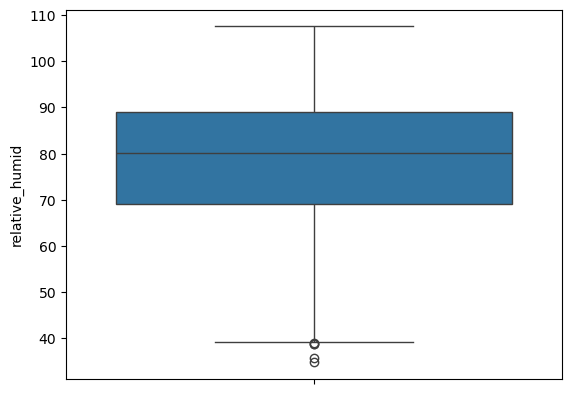

In [70]:
sns.boxplot(wtg_1_df['relative_humid'])

In [71]:
from astral import LocationInfo
from astral.sun import sun
import pytz

location = LocationInfo("Seoul", "South Korea", "Asia/Seoul", 35.24211, 126.3246)

# 밤/낮 feature 추가

def is_day_or_night(dt):
    s = sun(location.observer, date=dt)
    sunrise = s['sunrise']
    sunset = s['sunset']
    dt = dt.tz_localize('Asia/Seoul')
    if sunrise < dt < sunset:
        return 0  # Day
    else:
        return 1  # Night

wtg_1_df['Day/Night'] = wtg_1_df['DateTime'].apply(is_day_or_night)
wtg_1_df.head()


,DateTime,elevation,land_cover,surf_rough,frictional_vmax_50m,frictional_vmin_50m,pressure,relative_humid,specific_humid,temp_air,...,turbine_id,plant_name,period_hours,energy_kwh,wind_speed,wind_direction,wind_dir_sin,wind_dir_cos,cluster,Day/Night
0,2020-01-02 00:00:00,0.15625,0.021042,0.004259,3.177766,2.558847,103028.843750,61.177334,0.003413,280.260773,...,WTG01,영광풍력,1,0.000000,5.556939,329.241730,-0.511417,0.859333,0,1
1,2020-01-02 01:00:00,0.15625,0.021042,0.004250,3.907736,3.248139,103004.507812,61.698036,0.003413,280.260681,...,WTG01,영광풍력,1,1.169457,4.866656,320.563873,-0.635218,0.772333,0,1
2,2020-01-02 02:00:00,0.15625,0.021042,0.004248,3.552126,3.160641,102999.546875,62.101166,0.003418,280.268921,...,WTG01,영광풍력,1,5.299800,4.622301,319.445862,-0.650166,0.759792,0,1
3,2020-01-02 03:00:00,0.15625,0.021042,0.004248,3.269210,2.882998,102988.968750,61.944283,0.003418,280.276672,...,WTG01,영광풍력,1,0.465343,4.609023,325.505798,-0.566323,0.824184,0,1
4,2020-01-02 04:00:00,0.15625,0.021042,0.004248,3.065275,2.887952,102937.523438,61.080189,0.003418,280.266052,...,WTG01,영광풍력,1,0.000000,4.786076,325.963867,-0.559716,0.828685,0,1


In [72]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

wtg_1_df.columns = wtg_1_df.columns.str.replace(r'[<>\[\]]', '_', regex=True)
wtg_1_df.columns = wtg_1_df.columns.str.replace(r'[^\w]', '_', regex=True)
wtg_1_df.columns = wtg_1_df.columns.str.replace(r'__+', '_', regex=True)  # '__'를 '_'로 변경

# 숫자형 열만 선택
numeric_columns = wtg_1_df.select_dtypes(include=['float', 'int']).columns
numeric_columns = numeric_columns.drop(target)

# 숫자형 열에만 StandardScaler 적용
scaler = StandardScaler()
wtg_1_df[numeric_columns] = scaler.fit_transform(wtg_1_df[numeric_columns])


X = wtg_1_df[numeric_columns]

# target과 feature 분리
y = wtg_1_df[target]

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [73]:
wtg_1_df.columns

Index(['DateTime', 'elevation', 'land_cover', 'surf_rough',
       'frictional_vmax_50m', 'frictional_vmin_50m', 'pressure',
       'relative_humid', 'specific_humid', 'temp_air', 'storm_u_5m',
       'storm_v_5m', 'wind_u_10m', 'wind_v_10m', 'turbine_id', 'plant_name',
       'period_hours', 'energy_kwh', 'wind_speed', 'wind_direction',
       'wind_dir_sin', 'wind_dir_cos', 'cluster', 'Day_Night'],
      dtype='object')

In [74]:
X_train.columns

Index(['elevation', 'land_cover', 'surf_rough', 'frictional_vmax_50m',
       'frictional_vmin_50m', 'pressure', 'relative_humid', 'specific_humid',
       'temp_air', 'storm_u_5m', 'storm_v_5m', 'wind_u_10m', 'wind_v_10m',
       'period_hours', 'wind_speed', 'wind_direction', 'wind_dir_sin',
       'wind_dir_cos', 'cluster', 'Day_Night'],
      dtype='object')

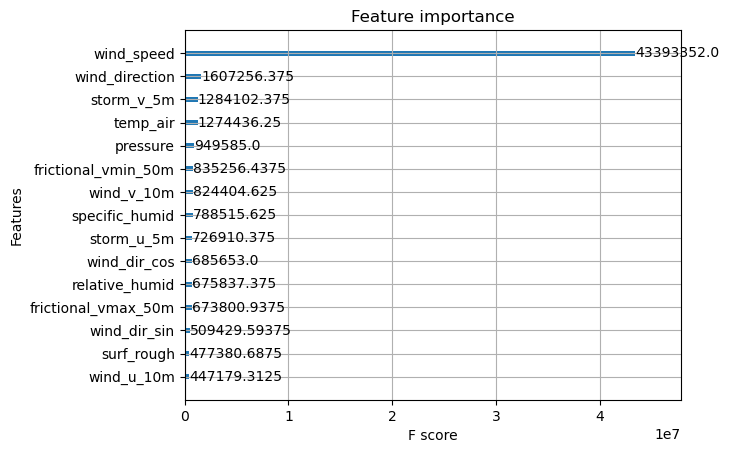

In [75]:

import matplotlib.pyplot as plt
import xgboost as xgb

# Train XGBoost model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
importances = model.feature_importances_
feature_names = X.columns


# Plot feature importances
xgb.plot_importance(model, importance_type = 'gain')
plt.show()

In [76]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd

model_name = []
r2score = []
rmse = []
nmae = []

models = [
    GradientBoostingRegressor(),
    SVR(),
    RandomForestRegressor(),
    LinearRegression(),
    ExtraTreesRegressor(),
    AdaBoostRegressor(),
    DecisionTreeRegressor(),
    XGBRegressor(),
    XGBRFRegressor(),
]

for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    model_name.append(model.__class__.__name__)
    r2score.append(r2_score(y_test, y_pred) * 100)
    rmse.append(mean_squared_error(y_test, y_pred, squared=False))
    
    # NMAE 계산
    mae = mean_absolute_error(y_test, y_pred)
    nmae.append(mae / y_test.mean()) 

models_df = pd.DataFrame({
    "Model-Name": model_name,
    "R2_score": r2score,
    'RMSE': rmse,
    'NMAE': nmae
})

models_df = models_df.astype({"R2_score": float, "RMSE": float, "NMAE": float})
models_df = models_df.sort_values("NMAE", ascending=False)


C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the func

In [77]:
print(models_df)

                  Model-Name   R2_score        RMSE      NMAE
5          AdaBoostRegressor  62.359017  390.926380  0.614587
1                        SVR  49.059730  454.773472  0.613531
3           LinearRegression  63.060301  387.267614  0.581317
6      DecisionTreeRegressor  60.485092  400.539165  0.492059
8             XGBRFRegressor  71.371715  340.927603  0.471396
0  GradientBoostingRegressor  73.085624  330.564840  0.453360
4        ExtraTreesRegressor  79.319450  289.764745  0.387222
2      RandomForestRegressor  79.208908  290.538141  0.386379
7               XGBRegressor  79.877029  285.831806  0.381999


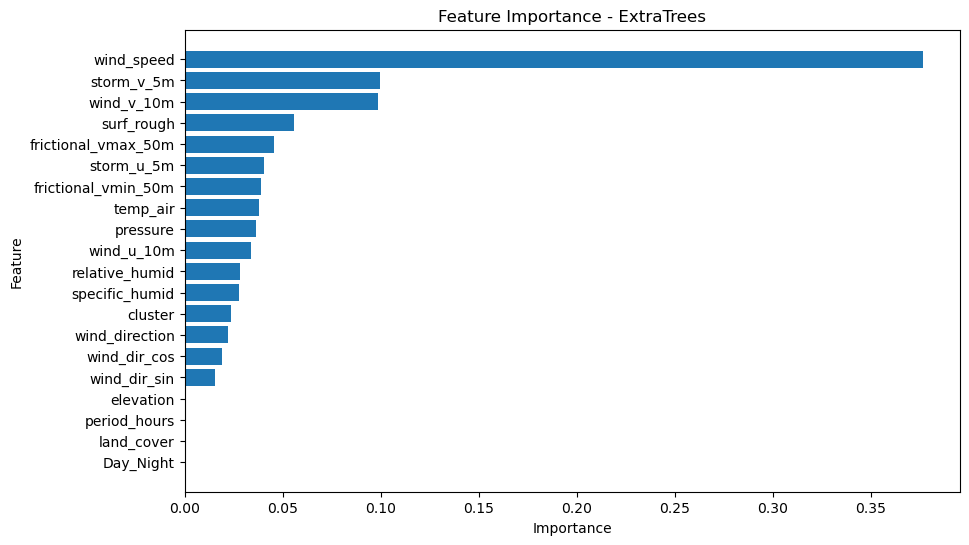

In [78]:
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
import pandas as pd

# ExtraTrees 모델 훈련
extra_trees_model = ExtraTreesRegressor()
extra_trees_model.fit(X_train, y_train)

# Feature 중요도 추출
importances = extra_trees_model.feature_importances_
feature_names = X.columns

# Feature 중요도 시각화
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - ExtraTrees')
plt.gca().invert_yaxis()
plt.show()


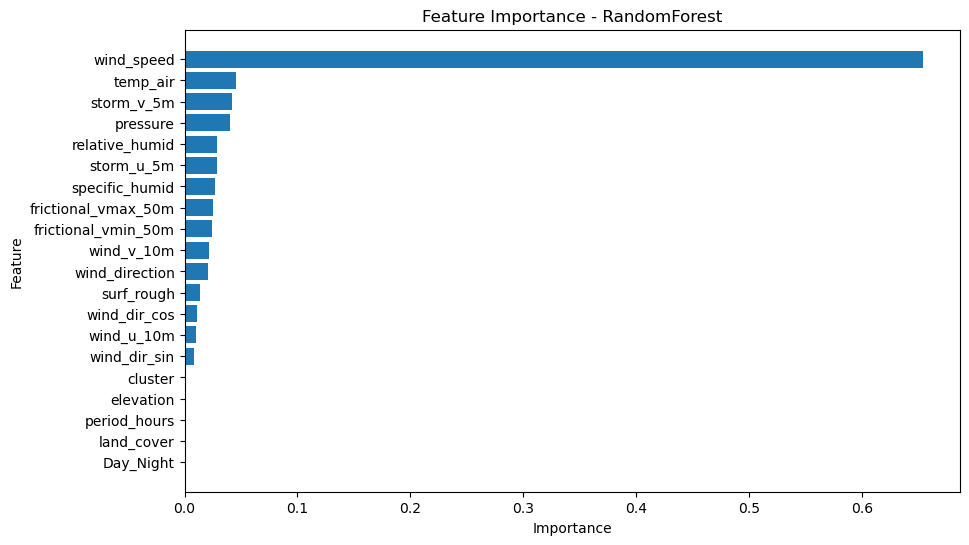

In [79]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import pandas as pd

# RandomForest 모델 훈련
random_forest_model = RandomForestRegressor()
random_forest_model.fit(X_train, y_train)

# Feature 중요도 추출
importances = random_forest_model.feature_importances_
feature_names = X.columns

# Feature 중요도 시각화
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - RandomForest')
plt.gca().invert_yaxis()
plt.show()
